##### Initialization

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, Flatten, TimeDistributed, ConvLSTM2D
from keras.layers.convolutional import Conv1D, MaxPooling1D
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from tabulate import tabulate

# Notebook

The folder time_series contains a list of files. Each file contains all the time series associated with a given product. Each time series corresponds to a company.

There are two types of files:

**- Wide**: each column corresponds to the time series of a company.

**- Long**: the information is stored in long format. The column company identifies the company, the colum timestamp the instant at which a price was recorded, and the column price the value of the price. These dataframes contain some other columns whose meaning will be explained next.

On the title of each file the Product Group (a product group corresponds to a group of time series of the same product sold by different companies) is identified by a number, called the product_group_id.

The file 'product_information' contains information about the products in each product group. This file contains the following columns:

- **offer_type** - offer type associated with that time series. A product can be locked, unlocked... to a certain operator.
- **product** - name of the product associated with time series
- **product_group_id** - uniquely identifies a product group. A product group is uniquely identified by its name and its offer_type.

**Example**: read a file and its product_information

In [2]:
# Select product_group_id
product_group_id = 958

In [3]:
# Read file
df_1 = pd.read_pickle("Data/time_series_1/wide_product_group_id_" + str(product_group_id))
df_1

,Abcdin,Falabella,Lider,Paris,Ripley,claro,entel,movistar,wom,vtr,macOnline
2020-06-21,NaN,291.085236,NaN,NaN,NaN,209.214955,316.346766,272.891840,229.127627,NaN,NaN
2020-06-22,NaN,291.085236,NaN,NaN,NaN,209.214955,316.346766,272.891840,229.127627,NaN,NaN
2020-06-23,NaN,291.085236,NaN,NaN,NaN,209.214955,316.346766,272.891840,229.127627,NaN,NaN
2020-06-24,NaN,291.085236,NaN,NaN,NaN,209.214955,316.346766,272.891840,229.127627,NaN,NaN
2020-06-25,NaN,291.085236,NaN,NaN,NaN,209.214955,316.346766,272.891840,229.127627,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2021-11-05,200.118257,NaN,NaN,NaN,200.118257,NaN,294.514691,191.021559,NaN,NaN,NaN
2021-11-06,200.118257,NaN,NaN,NaN,200.118257,NaN,294.514691,191.021559,NaN,NaN,NaN
2021-11-07,200.118257,NaN,NaN,NaN,200.118257,NaN,294.514691,191.021559,NaN,NaN,NaN
2021-11-08,200.118257,NaN,NaN,NaN,200.118257,NaN,294.514691,191.021559,NaN,NaN,NaN


In [4]:
# Read product information of the time series of that product group
product_information = pd.read_pickle("Data/product_information")
product_information.loc[product_group_id]

product       huawei Y9S 128GB
offer_type            unlocked
Name: 958, dtype: object

In [5]:
product_information

,product,offer_type
product_group_id,,
1,xiaomi Pocophone 128GB,unlocked
2,xiaomi Redmi Note 8 128GB,unlocked
5,xiaomi Redmi Note 9 Pro 64GB + AIWA AW 6,unlocked
6,xiaomi Redmi Note 9 Pro 64GB + AIWA AW 8,unlocked
7,blu Joy Adulto Mayor Sos,unlocked
...,...,...
952,huawei P30 128GB + P Smart 2019,unlocked
953,motorola Moto G7 Power 64GB,unlocked
956,nokia 6.1 32GB,unlocked


**Example**: convert a long dataframe to a wide format

In [6]:
df_long = pd.read_pickle("Data/time_series_1/long_product_group_id_" + str(product_group_id))
df_wide = df_long.reset_index().groupby(['timestamp', "company"])["price"].first().unstack().reset_index().set_index("timestamp")

# Fill missing timestamps
timestamps  = pd.DataFrame(index = pd.date_range(df_wide.index[0],df_wide.index[-1], freq='D'))
df_wide = pd.merge(timestamps, df_wide, left_index = True, right_index = True, how = 'left')
df_wide.columns.name = None

In [7]:
df_long

,product_id,timestamp,product,country,company,product_group_id,offer_type,price
422267,3217,2020-06-21,huawei Y9S 128GB,CL,movistar,958,unlocked,272.891840
422268,3217,2020-06-22,huawei Y9S 128GB,CL,movistar,958,unlocked,272.891840
422269,3217,2020-06-23,huawei Y9S 128GB,CL,movistar,958,unlocked,272.891840
422270,3217,2020-06-24,huawei Y9S 128GB,CL,movistar,958,unlocked,272.891840
422271,3217,2020-06-25,huawei Y9S 128GB,CL,movistar,958,unlocked,272.891840
...,...,...,...,...,...,...,...,...
426112,3230,2021-03-18,huawei Y9S 128GB,CL,Lider,958,unlocked,209.214955
426113,3230,2021-03-19,huawei Y9S 128GB,CL,Lider,958,unlocked,209.214955
426114,3230,2021-03-20,huawei Y9S 128GB,CL,Lider,958,unlocked,209.214955
426115,3230,2021-03-21,huawei Y9S 128GB,CL,Lider,958,unlocked,209.214955


In [8]:
df_wide

,Abcdin,Falabella,Lider,Paris,Ripley,claro,entel,movistar,wom
2020-06-21,NaN,291.085236,NaN,NaN,NaN,209.214955,316.346766,272.891840,229.127627
2020-06-22,NaN,291.085236,NaN,NaN,NaN,209.214955,316.346766,272.891840,229.127627
2020-06-23,NaN,291.085236,NaN,NaN,NaN,209.214955,316.346766,272.891840,229.127627
2020-06-24,NaN,291.085236,NaN,NaN,NaN,209.214955,316.346766,272.891840,229.127627
2020-06-25,NaN,291.085236,NaN,NaN,NaN,209.214955,316.346766,272.891840,229.127627
...,...,...,...,...,...,...,...,...,...
2021-11-05,200.118257,NaN,NaN,NaN,200.118257,NaN,294.514691,191.021559,NaN
2021-11-06,200.118257,NaN,NaN,NaN,200.118257,NaN,294.514691,191.021559,NaN
2021-11-07,200.118257,NaN,NaN,NaN,200.118257,NaN,294.514691,191.021559,NaN
2021-11-08,200.118257,NaN,NaN,NaN,200.118257,NaN,294.514691,191.021559,NaN


In [9]:
# fix random seed for reproducibility
np.random.seed(7)

def get_product_wide(product_group_id, time_series='2'):
    df_long = pd.read_pickle(f"Data/time_series_{time_series}/long_product_group_id_{product_group_id}")
    df_wide = df_long.reset_index().groupby(['timestamp', "company"])["price"].first().unstack().reset_index().set_index("timestamp")
    # Fill missing timestamps
    timestamps  = pd.DataFrame(index = pd.date_range(df_wide.index[0],df_wide.index[-1], freq='D'))
    df_wide = pd.merge(timestamps, df_wide, left_index = True, right_index = True, how = 'left')
    df_wide.columns.name = None
    
    
    return df_wide

In [10]:
get_product_wide(789, time_series='2').keys()

Index(['claro', 'movistar'], dtype='object')

<AxesSubplot:>

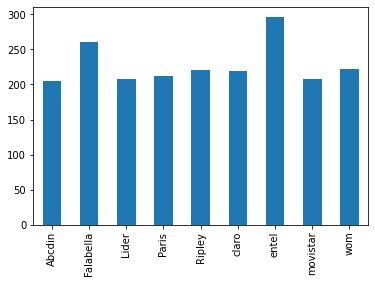

In [11]:
df_wide.mean().plot(kind='bar')

## Data Visualization

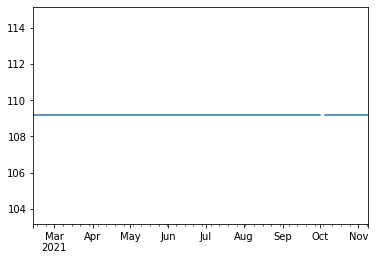

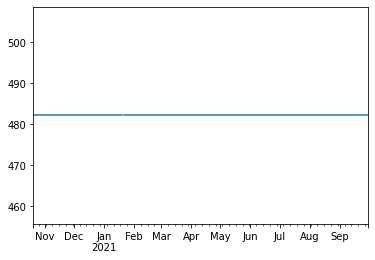

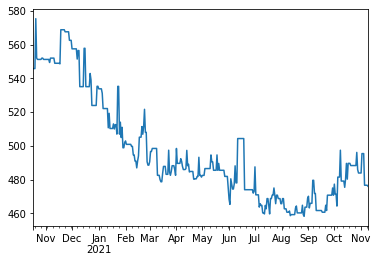

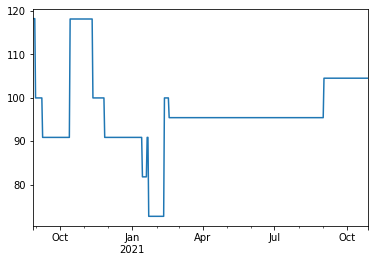

In [12]:
time_series = '2'

for i, file in enumerate(glob.glob(f"Data/time_series_{time_series}/*")):
    product_group_id = file.split("_")[-1]
    df_wide = get_product_wide(product_group_id, time_series)
    
    df_wide.mean(axis=1).plot()
    plt.show()
    if i == 3:
        break

In [13]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)


time_series = '2'
company = "movistar"
n_steps = 7 # number of days
train_split_amount = 0.7

X_train = np.empty(shape=[0, n_steps], dtype=np.float32)
y_train = np.array([], dtype=np.float32)
X_test = np.empty(shape=[0, n_steps], dtype=np.float32)
y_test = np.array([], dtype=np.float32)

for i, file in enumerate(glob.glob(f"Data/time_series_{time_series}/*")):
    product_group_id = file.split("_")[-1]
    df_wide = get_product_wide(product_group_id, time_series)
    if company in df_wide.keys():
        # DROP NAN VALUES
        prices = df_wide[company].dropna().values

        # SPLIT THE TIME SERIES OF PRICES INTO SEVERAL SHORT SEQUENCES
        X, y = split_sequence(prices, n_steps)
        
        # SPLIT INTO TRAIN AND TEST DATA
        train_size = int(len(y) * train_split_amount)
        test_size = len(y) - train_size
        
        # ADD DATA TO DATASET
        X_train = np.concatenate((X_train, X[0:train_size,:]))
        y_train = np.append(y_train, y[0:train_size])
        X_test = np.concatenate((X_test, X[train_size:,:]))
        y_test = np.append(y_test, y[train_size:])

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(19758, 7)
(19758,)
(8516, 7)
(8516,)


## Normalizing the data

In [14]:
scaler = MinMaxScaler(feature_range=(0, 1))

# fit and apply the scaler on the TRAINING data
X_train = scaler.fit_transform(X_train)

# apply scaler on the TEST data
X_test = scaler.transform(X_test)

# Univariate Models

In [15]:
# We are working with a univariate series, so the number of features is one, for one variable.
n_features = 1
# reshape from [samples, timesteps] into [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))
print(X_train.shape)
print(X_test.shape)

(19758, 7, 1)
(8516, 7, 1)


In [16]:
model_results = []

In [17]:
# define evaluation metrics
def evaluate_pred(y_pred, y_test):
    mse = mean_squared_error(y_test, y_pred)
    mae = round(mean_absolute_error(y_test, y_pred), 4)
    rmse = str(round(np.sqrt(mse), 4))
    rmsle = str(round(np.log(np.sqrt(mse)), 4))
    mse = str(round(mse, 4))
    r2 = r2_score(y_test, y_pred)
    n = X_test.shape[0]
    k = X_test.shape[1]
    adjusted_r2 = str(round(1 - ((1-r2) * ((n-1)/(n-k-1))), 4))
    r2 = str(round(r2, 4))

    table = [
        ["Mean Absolute Error (MAE)", mae],
        ["Mean Squared Error (MSE)", mse],
        ["Root Mean Squared Error (RMSE)", rmse],
        ["Root Mean Squared Log Error (RMSLE)", rmsle],
        ["R Squared (R2)", r2],
        ["Adjusted R Squared (AR2)", adjusted_r2],
    ]
    print()
    print(tabulate(table, headers=["Metric", "Value"]))

    return [x[1] for x in table]

In [18]:
n_epochs = 200
verbose = 0

# define evaluation strategy
def train_and_test_model(model, n_epochs=200, verbose=0):
    # fit model
    model.fit(X_train, y_train, epochs=n_epochs, verbose=verbose)

    # get predictions on test data
    y_pred = model.predict(X_test, verbose=verbose)

    return y_pred

## Vanilla LSTM

In [19]:
# define model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                10400     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [20]:
# fit the model with the training data and
# get its' price predictions on the test data
y_pred = train_and_test_model(model)

In [21]:
# evaluate the model predictions
metrics = evaluate_pred(y_pred, y_test)
metrics.insert(0, "Vanilla LSTM")
model_results.append(metrics)


Metric                                  Value
-----------------------------------  --------
Mean Absolute Error (MAE)              2.4634
Mean Squared Error (MSE)             236.348
Root Mean Squared Error (RMSE)        15.3736
Root Mean Squared Log Error (RMSLE)    2.7327
R Squared (R2)                         0.9956
Adjusted R Squared (AR2)               0.9956


## Stacked LSTM

In [22]:
# define model
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 7, 50)             10400     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


In [23]:
# fit the model with the training data and
# get its' price predictions on the test data
y_pred = train_and_test_model(model)

In [24]:
# evaluate the model predictions
metrics = evaluate_pred(y_pred, y_test)
metrics.insert(0, "Stacked LSTM")
model_results.append(metrics)


Metric                                  Value
-----------------------------------  --------
Mean Absolute Error (MAE)              1.5641
Mean Squared Error (MSE)             132.982
Root Mean Squared Error (RMSE)        11.5318
Root Mean Squared Log Error (RMSLE)    2.4451
R Squared (R2)                         0.9975
Adjusted R Squared (AR2)               0.9975


## Bidirectional LSTM

In [25]:
model = Sequential()
model.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [26]:
# fit the model with the training data and
# get its' price predictions on the test data
y_pred = train_and_test_model(model)

In [27]:
# evaluate the model predictions
metrics = evaluate_pred(y_pred, y_test)
metrics.insert(0, "Bidirectional LSTM")
model_results.append(metrics)


Metric                                  Value
-----------------------------------  --------
Mean Absolute Error (MAE)              2.255
Mean Squared Error (MSE)             132.082
Root Mean Squared Error (RMSE)        11.4927
Root Mean Squared Log Error (RMSLE)    2.4417
R Squared (R2)                         0.9975
Adjusted R Squared (AR2)               0.9975


## CNN LSTM

In [28]:
time_series = '2'
company = "movistar"
n_steps = 8 # number of days
train_split_amount = 0.7

X_train = np.empty(shape=[0, n_steps], dtype=np.float32)
y_train = np.array([], dtype=np.float32)
X_test = np.empty(shape=[0, n_steps], dtype=np.float32)
y_test = np.array([], dtype=np.float32)

for i, file in enumerate(glob.glob(f"Data/time_series_{time_series}/*")):
    product_group_id = file.split("_")[-1]
    df_wide = get_product_wide(product_group_id, time_series)
    if company in df_wide.keys():
        # DROP NAN VALUES
        prices = df_wide[company].dropna().values

        # SPLIT THE TIME SERIES OF PRICES INTO SEVERAL SHORT SEQUENCES
        X, y = split_sequence(prices, n_steps)
        
        # SPLIT INTO TRAIN AND TEST DATA
        train_size = int(len(y) * train_split_amount)
        test_size = len(y) - train_size
        
        # ADD DATA TO DATASET
        X_train = np.concatenate((X_train, X[0:train_size,:]))
        y_train = np.append(y_train, y[0:train_size])
        X_test = np.concatenate((X_test, X[train_size:,:]))
        y_test = np.append(y_test, y[train_size:])

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(19716, 8)
(19716,)
(8490, 8)
(8490,)


In [29]:
scaler = MinMaxScaler(feature_range=(0, 1))
# fit and apply the scaler on the TRAINING data
X_train = scaler.fit_transform(X_train)
# apply scaler on the TEST data
X_test = scaler.transform(X_test)

# reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
n_features = 1
n_seq = 2
n_sub_steps = 4
X_train = X_train.reshape((X_train.shape[0], n_seq, n_sub_steps, n_features))
X_test = X_test.reshape((X_test.shape[0], n_seq, n_sub_steps, n_features))
print(X_train.shape)
print(X_test.shape)


(19716, 2, 4, 1)
(8490, 2, 4, 1)


In [30]:
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, n_sub_steps, n_features)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [31]:
# fit the model with the training data and
# get its' price predictions on the test data
y_pred = train_and_test_model(model)

In [32]:
# evaluate the model predictions
metrics = evaluate_pred(y_pred, y_test)
metrics.insert(0, "CNN LSTM")
model_results.append(metrics)


Metric                                  Value
-----------------------------------  --------
Mean Absolute Error (MAE)              3.5912
Mean Squared Error (MSE)             260.648
Root Mean Squared Error (RMSE)        16.1446
Root Mean Squared Log Error (RMSLE)    2.7816
R Squared (R2)                         0.9951
Adjusted R Squared (AR2)               0.9951


## ConvLSTM

In [33]:
X_train = X_train.reshape((X_train.shape[0], n_seq, 1, n_sub_steps, n_features))
X_test = X_test.reshape((X_test.shape[0], n_seq, 1, n_sub_steps, n_features))

In [34]:
model = Sequential()
model.add(ConvLSTM2D(filters=64, kernel_size=(1,2), activation='relu', input_shape=(n_seq, 1, n_sub_steps, n_features)))
model.add(Flatten())
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [35]:
# fit the model with the training data and
# get its' price predictions on the test data
y_pred = train_and_test_model(model)

In [36]:
# evaluate the model predictions
metrics = evaluate_pred(y_pred, y_test)
metrics.insert(0, "ConvLSTM")
model_results.append(metrics)


Metric                                  Value
-----------------------------------  --------
Mean Absolute Error (MAE)              1.8873
Mean Squared Error (MSE)             134.734
Root Mean Squared Error (RMSE)        11.6075
Root Mean Squared Log Error (RMSLE)    2.4517
R Squared (R2)                         0.9975
Adjusted R Squared (AR2)               0.9975


## Model Results

In [37]:
print(tabulate(model_results,
               headers=["Univariate Model", "MAE", "MSE", "RMSE", "RMSLE", "R2", "AR2"], tablefmt='latex_booktabs'
               ))

tabulate(model_results,
         headers=["Univariate Model", "MAE", "MSE", "RMSE", "RMSLE", "R2", "AR2"], tablefmt='html'
         )


\begin{tabular}{lrrrrrr}
\toprule
 Univariate Model   &    MAE &     MSE &    RMSE &   RMSLE &     R2 &    AR2 \\
\midrule
 Vanilla LSTM       & 2.4634 & 236.348 & 15.3736 &  2.7327 & 0.9956 & 0.9956 \\
 Stacked LSTM       & 1.5641 & 132.982 & 11.5318 &  2.4451 & 0.9975 & 0.9975 \\
 Bidirectional LSTM & 2.255  & 132.082 & 11.4927 &  2.4417 & 0.9975 & 0.9975 \\
 CNN LSTM           & 3.5912 & 260.648 & 16.1446 &  2.7816 & 0.9951 & 0.9951 \\
 ConvLSTM           & 1.8873 & 134.734 & 11.6075 &  2.4517 & 0.9975 & 0.9975 \\
\bottomrule
\end{tabular}


Univariate Model,MAE,MSE,RMSE,RMSLE,R2,AR2
Vanilla LSTM,2.4634,236.348,15.3736,2.7327,0.9956,0.9956
Stacked LSTM,1.5641,132.982,11.5318,2.4451,0.9975,0.9975
Bidirectional LSTM,2.255,132.082,11.4927,2.4417,0.9975,0.9975
CNN LSTM,3.5912,260.648,16.1446,2.7816,0.9951,0.9951
ConvLSTM,1.8873,134.734,11.6075,2.4517,0.9975,0.9975
